# Deformable Attention

- 可变形注意力机制
- ref：[《Deformable DETR: Deformable Transformers for End-to-End Object Detection》](http://arxiv.org/abs/2010.04159)


In [1]:
import seaborn as sns
import numpy as np

## 经典Transformer中的注意力机制和可变形注意力机制

- **经典注意力机制**
$$\begin{aligned}
\text{score} &= \text{simility}(Q, K) \\
\text{output} &= \text{score} \cdot V
\end{aligned}$$


![可变形注意力机制示意图](https://foruda.gitee.com/images/1721673147889889358/8dfbbbe4_5218658.png)

在可变形注意力机制中，`input_spatial_shapes` 主要用于对偏移量进行归一化，从而将采样点的位置限制在一定的范围内。具体而言：

1. **偏移量归一化**：在计算采样点时，可变形注意力机制会根据参考点 (`reference_points`) 和偏移量 (`sampling_offsets`) 得出采样点的位置。为了确保采样点位置的合理性，需要使用 `input_spatial_shapes` 对偏移量进行归一化。这样可以避免采样点超出序列的长度或特征图的尺寸。

2. **空间坐标映射**：在 `sampling_locations` 的计算中，偏移量被除以 `input_spatial_shapes`，这是为了将偏移量映射到输入序列的空间坐标系统中。`input_spatial_shapes` 代表了输入特征图的空间维度（在你的例子中是 `sequence_length` 和 `1`），通过这个映射，偏移量可以从 [0, 1] 范围内的归一化坐标转换为实际的空间位置。

3. **确保采样点的合理性**：由于 `input_spatial_shapes` 的存在，采样点的位置能够确保在合理的范围内，从而避免采样点落在特征图之外，这对于模型的稳定性和有效性非常重要。

在实际应用中，`input_spatial_shapes` 通常是表示特征图的宽度和高度，在一维的情况下，它表示序列的长度。而在二维的情况下，它可能是形如 `(H, W)` 的形状，用于对二维的偏移量进行归一化。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
class Attention(nn.Module):#经典Transformer注意力机制
    """为了简化演示，使用1维单头注意力，并且略去Q、K、V和输出的投影"""
    def __init__(self, hidden_size: int = 16):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size

    def compute_score(self, q: torch.Tensor, k: torch.Tensor):
        score = torch.matmul(q, k.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        return F.softmax(score, dim=-1)

    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor):
        # 计算注意力分数
        score = self.compute_score(q, k)

        # 加权求和
        output = torch.matmul(score, v)
        return output, score
    
class DeformableAttention(nn.Module):
    """可变形注意力，这里同样是1维的单头注意力，略去Q、K、V和输出的投影"""
    def __init__(self, hidden_size: int = 16, n_points: int = 2):
        super().__init__()
        self.hidden_size = hidden_size  # 隐藏层维度，默认为16
        self.n_points = n_points  # 可变形注意力的采样点数量,就是公式里的k
        # 用于估计偏移量,和图中的对应，是可学习的参数
        self.sampling_offsets = nn.Linear(hidden_size, n_points * 1 * 2)  # n_points个偏移量 * n_heads * 2d
        # 用于估计权重，和图中的对应
        self.attention_weights = nn.Linear(hidden_size, n_points * 1)  # n_points个权重 * n_heads

    def esitimate_offset_and_weights(self, q: torch.Tensor, reference_points: torch.Tensor):
        """根据查询，估计偏移量
        Args:
            q: Query，形状为(batch_size, sequence_length, hidden_size)
            reference_points: 参考点，形状为(batch_size, sequence_length, 2)
        Returns:
            offset: 偏移量，形状为(batch_size, sequence_length, n_points, 2)
            weights: 权重，形状为(batch_size, sequence_length, n_points)
        """
        # 估计偏移量，通过线性层将query映射到偏移量空间
        offset = self.sampling_offsets(q)
        # 估计权重，通过线性层将query映射到权重空间
        weights = self.attention_weights(q)  # 权重的维度为 (batch_size, sequence_length, n_points * 1)
        # 权重归一化, 使用softmax使得权重和为1
        weights = F.softmax(weights, dim=-1)  # 权重的维度为 (batch_size, sequence_length, n_points)
        # 返回的偏移量形状为 (batch_size, sequence_length, n_points, 2)，权重的形状为 (batch_size, sequence_length, n_points)。
        return offset.reshape(q.shape[0], q.shape[1], self.n_points, 2), weights
    
    def ground_truth_offset_and_weights(self, q: torch.Tensor, reference_points: torch.Tensor):
        """这里为了演示，直接用真实的偏移量，而非去训练一个线性层来估计偏移量，所以这里不重要，可以不看"""
        # 计算偏移量
        # random_offset.shape = (batch_size, sequence_length, n_points, 2) 有4个采样点
        bs, seq_len , _ = q.shape
        random_offset = torch.randint(0, seq_len, (bs, seq_len, self.n_points, 2)) #随机生成偏移量(x,y)
        random_offset[:, :, :, 1] = 0. #y方向的偏移量为0
        random_offset[:, :, 1, 0] = random_offset[:, :, 1, 0] - reference_points[:, :, 0] * seq_len #第一个采样点x方向的偏移量做了调整
        ground_truth_offset = random_indexes - reference_points[:, :, 0] * seq_len #random_indexes是我们真实的偏移量
        random_offset[:, :, 0, 0] = ground_truth_offset #ground_truth_offset 表示第0个点的真实偏移量，并将其赋值给 random_offset 的相应位置。最终 offset 是包含所有偏移量的张量。
        offset = random_offset       # offset.shape = (batch_size, sequence_length, n_points, 2)


        # 计算权重
        weights = torch.ones(offset.shape[:-1]) # 权重初始化为1
        weights[:, :, 0] = 0.8 # 第一个权重为0.8
        weights[:, :, 1:] = 0.2 / (self.n_points - 1) # 其他权重为0.2/(n_points-1)
        # 该方法返回的偏移量和权重与估计偏移量和权重类似
        return offset, weights
        
    def forward(self, 
                q: torch.Tensor, 
                v: torch.Tensor,  # input feature map x
                reference_points: torch.Tensor, 
                input_spatial_shapes: torch.Tensor,  # 输入特征图的空间形状
                using_ground_truth: bool = False):
        """
        Args:
            q: Query，形状为(batch_size, sequence_length, hidden_size)
            v: Value，形状为(batch_size, sequence_length, hidden_size)
            reference_points: 参考点，形状为(batch_size, sequence_length, 2)
            input_spatial_shapes: 输入的空间形状，这个例子中为 (sequence_length, 1)
            using_ground_truth: 布尔值，是否使用真实的偏移量和权重。
        Returns:
            output: 输出，形状为(batch_size, sequence_length, hidden_size)
        """
        # 根据参数选择使用真实偏移量和权重还是估计的偏移量和权重
        if using_ground_truth:
            sampling_offsets, weights = self.ground_truth_offset_and_weights(q, reference_points)
        else:
            sampling_offsets, weights = self.esitimate_offset_and_weights(q, reference_points)
        # sampling_offsets.shape = (batch_size, sequence_length, n_points, 2)
        # weights.shape = (batch_size, sequence_length, n_points)

        # 获得采样点，sampling_locations 的形状为 (batch_size, sequence_length, n_points, 2)。
        offset_normalizer = input_spatial_shapes # 输入的空间形状，里边值是(8和1）
        # 结合参考点和偏移量计算出采样点的位置。参考点的位置加上偏移量就是最终的采样点位置,reference_points形状为(batch_size, sequence_length, 2)
        print(f'offset_normalizer.shape: {offset_normalizer[None, None, None, :].shape}')
        # 结合参考点和偏移量计算出采样点的位置。参考点位置加上归一化后的偏移量得到最终采样点位置,这里是增维，类似于unsqueeze
        sampling_locations = reference_points[:, :, None, :] + sampling_offsets / offset_normalizer[None, None, None, :]
        # 打印采样位置的形状，用于调试
        print(f'sampling_locations.shape: {sampling_locations.shape}')
        # 将采样点位置从[0,1]范围映射回输入序列的实际长度
        sampling_locations_absolute = sampling_locations * input_spatial_shapes[None, None, None, :]
        
        # 调整value张量的维度顺序，以便于后续的grid_sample操作
        # v.shape bs, seq_len, hidden_size -> bs, hidden_size, seq_len（1,16,8）,hidden_size是16
        v = v.permute(0, 2, 1)
        # 使用grid_sample从value中采样特征，align_corners=True确保边界对齐，sampled_values 的形状为 (batch_size, sequence_length, n_points, hidden_size)
        sampled_values = F.grid_sample(v.unsqueeze(-1), sampling_locations, align_corners=True)
        # 打印采样值的形状，用于调试
        print(f'sampled_values.shape: {sampled_values.shape}')
        # 调整采样值的维度顺序，以便于后续的加权求和
        # sampled_values.shape = (bs, hidden_size, seq_len, n_points) -> (bs, seq_len, n_points, hidden_size)
        print(f'sampled_values.shape: {sampled_values.shape}')
        sampled_values = sampled_values.permute(0, 2, 3, 1)#(bs, seq_len, n_points, hidden_size)
        # 对采样的特征值进行加权求和，得到最终的输出 output，形状为 (batch_size, sequence_length, hidden_size)。
        output = torch.sum(sampled_values * weights.unsqueeze(-1), dim=-2) 

        # 返回输出和调试信息（采样位置和权重）
        return output, (sampling_locations_absolute, weights)  # output(bs, seq_len, hidden_size)

    
# 对应Query q: 用来计算采样的偏移量 (sampling_offsets) 和注意力权重 (attention_weights)。
dummy_query = torch.randn(1, 8, 16)  # batch_size=1, sequence_length=8, hidden_size=16
#对应 输入特征图 (input feature map x)，backbone（例如ResNet）的输出，形状为 (batch_size, sequence_length, hidden_size)
dummy_value = torch.randn(1, 8, 16)  # batch_size=1, sequence_length=8, hidden_size=16
# 位置索引
indexes = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]).unsqueeze(0)
# 随机索引
random_indexes = torch.randperm(8)
print("random_indexes", random_indexes)
# 这里的 key 是 query 的一个随机排列
dummy_key = dummy_query[:, random_indexes]

# 初始化注意力
attention = Attention()
# 计算注意力
output, classic_score = attention(
    q=dummy_query, 
    k=dummy_key, 
    v=dummy_value
    )

# print("== classic attention ==")
# print("output shape", output.shape)
# print("attention score shape", classic_score.shape)

# 初始化可变形注意力
n_points = 3
deformable_attention = DeformableAttention(n_points=n_points)
# 计算参考点
reference_points = torch.tensor([
    [0, 0],
    [1, 0],
    [2, 0],
    [3, 0],
    [4, 0],
    [5, 0],
    [6, 0],
    [7, 0]
]).reshape(1, 8, 2)  # batch_size=1, sequence_length=8, 2D(x,y)
reference_points = reference_points / 8 # 参考点的值在 0~1 之间 

# 计算注意力,在bevformer的decoder中，q是随机的，v是encoder的输出，k是空的
output, (loc, deformable_score) = deformable_attention(
    q=dummy_query,
    v=dummy_value, 
    reference_points=reference_points,
    input_spatial_shapes=torch.tensor([8, 1]),
    using_ground_truth=True
    )

#上面的loc主要是为了可视化
print("== deformable attention ==")
print("output shape", output.shape) #通过可变形注意力机制生成的加权特征值，形状为 (batch_size, sequence_length, hidden_size)。
print("deformable attention score shape", deformable_score.shape) # 是注意力权重，形状为 (batch_size, sequence_length, n_points)。


random_indexes tensor([1, 5, 2, 3, 7, 4, 0, 6])
offset_normalizer.shape: torch.Size([1, 1, 1, 2])
sampling_locations.shape: torch.Size([1, 8, 3, 2])
sampled_values.shape: torch.Size([1, 16, 8, 3])
sampled_values.shape: torch.Size([1, 16, 8, 3])
== deformable attention ==
output shape torch.Size([1, 8, 16])
deformable attention score shape torch.Size([1, 8, 3])


`torch.nn.functional.grid_sample` 是 PyTorch 中的一个函数，主要用于对图像或特征图进行采样和变换。它常用于图像处理、计算机视觉任务中，特别是在实现空间变换网络（Spatial Transformer Networks, STN）时。

### 核心作用
`grid_sample` 函数可以根据输入的采样网格 (`grid`) 对输入张量 (`input`) 进行采样，返回经过变换后的输出张量。它支持各种形式的空间变换，如仿射变换、透视变换等。

### 参数
- **input**: 输入张量，通常是 4D 张量，形状为 `(N, C, H, W)`，分别表示批次大小、通道数、高度和宽度。
- **grid**: 采样网格，通常也是 4D 张量，形状为 `(N, H_out, W_out, 2)`，表示在输出空间中每个位置对应输入空间的位置。每个位置用一对坐标 (x, y) 来表示，其中 x 和 y 的范围是 [-1, 1]，分别对应输入图像的左上角和右下角。

### 工作原理
`grid_sample` 函数根据 `grid` 中的坐标，从 `input` 张量中采样相应的像素值。采样时可以选择不同的插值方式（例如双线性插值）和填充方式（例如边界填充或反射填充）。

### 主要选项
- **mode**: 插值模式，默认是 `'bilinear'`，可以选择 `'nearest'`（最近邻插值）或 `'bilinear'`（双线性插值）。
- **padding_mode**: 当采样点落在输入范围之外时的填充模式。选项有 `'zeros'`（填充0）、 `'border'`（使用边界值填充）、`'reflection'`（反射填充）。
- **align_corners**: 如果为 `True`，则 `grid` 的坐标对齐方式是角点对齐；如果为 `False`，则是中心点对齐。

### 示例
```python
import torch
import torch.nn.functional as F

# 创建一个示例输入张量
input = torch.arange(1., 10.).view(1, 1, 3, 3)

# 创建一个采样网格
grid = torch.tensor([[[[-1, -1], [1, -1], [-1, 1], [1, 1]]]]).view(1, 2, 2, 2)

# 应用 grid_sample
output = F.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

print(output)
```

### 输出
```plaintext
tensor([[[[1., 3.],
          [7., 9.]]]])
```

### 应用场景
- **图像变换**: `grid_sample` 常用于应用仿射变换、透视变换或其他空间变换。
- **空间变换网络（STN）**: STN 是一种可以学习空间变换的网络结构，`grid_sample` 是其核心操作之一，用于根据变换参数生成变换后的图像或特征图。

通过 `grid_sample` 函数，你可以灵活地对图像或特征图进行采样和变换，帮助神经网络适应不同的视角或尺度变化。

In [3]:
# 创建一个示例输入张量
input = torch.arange(1., 10.).view(1, 1, 3, 3)
print(input)
# 创建一个采样网格
grid = torch.tensor([[[[-1, -1], [1, -1], [-1, 1], [1, 1]]]]).view(1, 2, 2, 2).float()
print(grid)
# 应用 grid_sample
output = F.grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

print(output)

tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
tensor([[[[-1., -1.],
          [ 1., -1.]],

         [[-1.,  1.],
          [ 1.,  1.]]]])
tensor([[[[1., 3.],
          [7., 9.]]]])


## 可视化注意力图

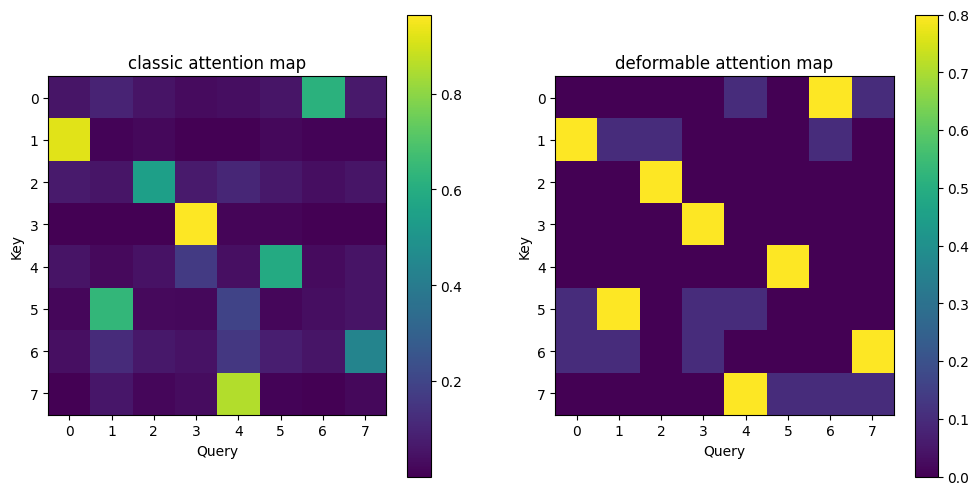

In [4]:
# loc.shape = (bs, seq_len, n_points, 2d)
# 重建可变形注意力的完整注意力权重
full_score = torch.zeros(8, 8)
for i in range(8):
    for j in range(n_points-1, -1, -1):
        idx = max(0, min(7, int(loc[0, i, j, 0].item() + 0.5)))
        full_score[idx, i] = deformable_score[0, i, j].item()

# 用热力图绘制两张注意力权重
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(classic_score[0], interpolation='nearest')
plt.colorbar()
plt.xlabel('Query')
plt.ylabel('Key')
plt.title('classic attention map')

plt.subplot(1, 2, 2)
plt.imshow(full_score, interpolation='nearest')
plt.colorbar()
plt.xlabel('Query')
plt.ylabel('Key')
plt.title('deformable attention map')

plt.show()

In [5]:
class DeformableAttention(nn.Module):
    """可变形注意力，这里同样是1维的单头注意力，略去Q、K、V和输出的投影"""
    def __init__(self, hidden_size: int = 16, n_points: int = 2):
        super(DeformableAttention, self).__init__()
        self.hidden_size = hidden_size
        self.n_points = n_points  # 可变形注意力的采样点数量
        # 用于估计偏移量,和图中的对应
        self.sampling_offsets = nn.Linear(hidden_size, n_points * 1 * 2)  # n_points个偏移量 * n_heads * 2d
        # 用于估计权重，和图中的对应
        self.attention_weights = nn.Linear(hidden_size, n_points * 1)  # n_points个权重 * n_heads

    def esitimate_offset_and_weights(self, q: torch.Tensor, reference_points: torch.Tensor):
        """根据查询，估计偏移量
        Args:
            q: Query，形状为(batch_size, sequence_length, hidden_size)
            reference_points: 参考点，形状为(batch_size, sequence_length, 2)
        Returns:
            offset: 偏移量，形状为(batch_size, sequence_length, n_points, 2)
            weights: 权重，形状为(batch_size, sequence_length, n_points)
        """
        # 估计偏移量
        offset = self.sampling_offsets(q)
        # 估计权重
        weights = self.attention_weights(q)
        # 权重归一化
        weights = F.softmax(weights, dim=-1)
        return offset.reshape(q.shape[0], q.shape[1], self.n_points, 2), weights

    def ground_truth_offset_and_weights(self, q: torch.Tensor, reference_points: torch.Tensor):
        """这里为了演示，直接用真实的偏移量，而非去训练一个线性层来估计偏移量"""
        # 计算偏移量
        # random_offset.shape = (batch_size, sequence_length, n_points, 2)
        bs, seq_len , _ = q.shape
        random_offset = torch.randint(0, seq_len, (bs, seq_len, self.n_points, 2))
        random_offset[:, :, :, 1] = 0. #y方向的偏移量为0
        random_offset[:, :, 1, 0] = random_offset[:, :, 1, 0] - reference_points[:, :, 0] * seq_len
        ground_truth_offset = random_indexes - reference_points[:, :, 0] * seq_len #random_indexes是我们真实的偏移量
        random_offset[:, :, 0, 0] = ground_truth_offset #ground_truth_offset 表示第一个点的真实偏移量，并将其赋值给 random_offset 的相应位置。最终 offset 是包含所有偏移量的张量。
        offset = random_offset
        # offset.shape = (batch_size, sequence_length, n_points, 2)

        # 计算权重
        weights = torch.ones(offset.shape[:-1])
        weights[:, :, 0] = 0.8
        weights[:, :, 1:] = 0.2 / (self.n_points - 1)
        return offset, weights

    def forward(self,
                q: torch.Tensor,
                v: torch.Tensor,
                reference_points: torch.Tensor,
                input_spatial_shapes: torch.Tensor,
                using_ground_truth: bool = False):
        """
        Args:
            q: Query，形状为(batch_size, sequence_length, hidden_size)
            v: Value，形状为(batch_size, sequence_length, hidden_size)
            reference_points: 参考点，形状为(batch_size, sequence_length, 2)
            input_spatial_shapes: 输入的空间形状，这个例子中为 (sequence_length, 1)
            using_ground_truth: 布尔值，是否使用真实的偏移量和权重。
        Returns:
            output: 输出，形状为(batch_size, sequence_length, hidden_size)
        """
        # 估计偏移量和权重
        if using_ground_truth:
            sampling_offsets, weights = self.ground_truth_offset_and_weights(q, reference_points)
        else:
            sampling_offsets, weights = self.esitimate_offset_and_weights(q, reference_points)
        # sampling_offsets.shape = (batch_size, sequence_length, n_points, 2)
        # weights.shape = (batch_size, sequence_length, n_points)

        # 获得采样点，sampling_locations 的形状为 (batch_size, sequence_length, n_points, 2)。
        offset_normalizer = input_spatial_shapes
        sampling_locations = reference_points[:, :, None, :] + sampling_offsets / offset_normalizer[None, None, None, :] #计算后sampling_locations尺寸为（1，8，1，2）

        # 获得采样点的绝对位置
        sampling_locations_absolute = sampling_locations * input_spatial_shapes[None, None, None, :]

        # 根据[0~1]的采样点，反归一化到输入序列的长度
        # v.shape bs, seq_len, hidden_size -> bs, hidden_size, seq_len（1,16,8）
        v = v.permute(0, 2, 1)
        # 使用 grid_sample 从值 v 中采样特征，并调整形状以适应加权求和。sampled_values 的形状为 (batch_size, sequence_length, n_points, hidden_size)
        sampled_values = F.grid_sample(v.unsqueeze(-1), sampling_locations, align_corners=True)
        # sampled_values.shape = (bs, hidden_size, seq_len, n_points) -> (bs, seq_len, n_points, hidden_size)
        sampled_values = sampled_values.permute(0, 2, 3, 1)
        # 对采样的特征值进行加权求和，得到最终的输出 output，形状为 (batch_size, sequence_length, hidden_size)。
        output = torch.sum(sampled_values * weights.unsqueeze(-1), dim=-2)

        return output, (sampling_locations_absolute, weights)


# 生成随机数据
dummy_query = torch.randn(1, 8, 16)  # batch_size=1, sequence_length=8, hidden_size=16
dummy_value = torch.randn(1, 8, 16)  # batch_size=1, sequence_length=8, hidden_size=16
# 位置索引，为了保留原始图片的位置信息
indexes = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]).unsqueeze(0)
# 随机索引
random_indexes = torch.randperm(8)
print("random_indexes", random_indexes)
# 这里的 key 是 query 的一个随机排列
dummy_key = dummy_query[:, random_indexes]



# 初始化可变形注意力
n_points = 3
deformable_attention = DeformableAttention(n_points=n_points)
# 计算参考点
reference_points = torch.tensor([
    [0, 0],
    [1, 0],
    [2, 0],
    [3, 0],
    [4, 0],
    [5, 0],
    [6, 0],
    [7, 0]
]).reshape(1, 8, 2)  # batch_size=1, sequence_length=8, 2D
reference_points = reference_points / 8 # 参考点的值在 0~1 之间

# 计算注意力,在bevformer的decoder中，q是随机的，v是encoder的输出，k是空的
output, (loc, deformable_score) = deformable_attention(
    q=dummy_query,
    v=dummy_value,
    reference_points=reference_points,
    input_spatial_shapes=torch.tensor([8, 1]),
    using_ground_truth=True
    )

print("== deformable attention ==")
print("output shape", output.shape)
print("deformable attention score shape", deformable_score.shape)

random_indexes tensor([4, 3, 6, 1, 5, 0, 2, 7])
== deformable attention ==
output shape torch.Size([1, 8, 16])
deformable attention score shape torch.Size([1, 8, 3])
